In [1]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install -q git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d
!pip install -q timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 5.45 MiB/s, done.
Resolving deltas: 100% (68/68), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


In [2]:
!pip uninstall -q -y torch torchaudio

In [3]:
!pip install -q torch==2.1.1+cu121 torchaudio==2.1.1+cu121 torchvision==0.16.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 707.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/content/ImageBind')
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
import glob

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 42090769.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

100%|██████████| 4.47G/4.47G [01:14<00:00, 64.5MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [8]:
def extract_and_save_embeddings(dataloader, save_dir="embeddings"):
    os.makedirs(save_dir, exist_ok=True)
    batch_idx = 0
    for images, _ in dataloader:
        images = images.to(device)
        inputs = {ModalityType.VISION: images}
        with torch.no_grad():
            outputs = model(inputs)
            vision_embeddings = outputs[ModalityType.VISION].cpu()

        save_path = os.path.join(save_dir, f"embeddings_batch_{batch_idx}.pt")
        torch.save(vision_embeddings, save_path)
        print(f"Saved batch {batch_idx} embeddings to {save_path}")
        batch_idx += 1

In [9]:
extract_and_save_embeddings(dataloader)

Saved batch 0 embeddings to embeddings/embeddings_batch_0.pt
Saved batch 1 embeddings to embeddings/embeddings_batch_1.pt
Saved batch 2 embeddings to embeddings/embeddings_batch_2.pt
Saved batch 3 embeddings to embeddings/embeddings_batch_3.pt
Saved batch 4 embeddings to embeddings/embeddings_batch_4.pt
Saved batch 5 embeddings to embeddings/embeddings_batch_5.pt
Saved batch 6 embeddings to embeddings/embeddings_batch_6.pt
Saved batch 7 embeddings to embeddings/embeddings_batch_7.pt
Saved batch 8 embeddings to embeddings/embeddings_batch_8.pt
Saved batch 9 embeddings to embeddings/embeddings_batch_9.pt
Saved batch 10 embeddings to embeddings/embeddings_batch_10.pt
Saved batch 11 embeddings to embeddings/embeddings_batch_11.pt
Saved batch 12 embeddings to embeddings/embeddings_batch_12.pt
Saved batch 13 embeddings to embeddings/embeddings_batch_13.pt
Saved batch 14 embeddings to embeddings/embeddings_batch_14.pt
Saved batch 15 embeddings to embeddings/embeddings_batch_15.pt
Saved batch 

In [10]:
def load_saved_embeddings(save_dir="/content/embeddings"):
    all_embeddings = []
    for file_path in sorted(glob.glob(os.path.join(save_dir, "embeddings_batch_*.pt"))):
        batch_embeddings = torch.load(file_path)
        all_embeddings.append(batch_embeddings)
    combined_embeddings = torch.cat(all_embeddings)
    return combined_embeddings

In [11]:
image_embeddings = load_saved_embeddings()
print("Combined embeddings shape:", image_embeddings.shape)

Combined embeddings shape: torch.Size([10000, 1024])


In [12]:
embeddings_array = image_embeddings.numpy()
print("Embeddings as NumPy array:", embeddings_array.shape)

Embeddings as NumPy array: (10000, 1024)


In [13]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings_array)

labels = kmeans.labels_
print("Cluster labels:", labels)

Cluster labels: [1 7 7 ... 3 1 6]


In [14]:
for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    print(f"Cluster {cluster_id}: {len(cluster_indices)} items")

Cluster 0: 382 items
Cluster 1: 911 items
Cluster 2: 980 items
Cluster 3: 1842 items
Cluster 4: 604 items
Cluster 5: 1350 items
Cluster 6: 1003 items
Cluster 7: 995 items
Cluster 8: 995 items
Cluster 9: 938 items


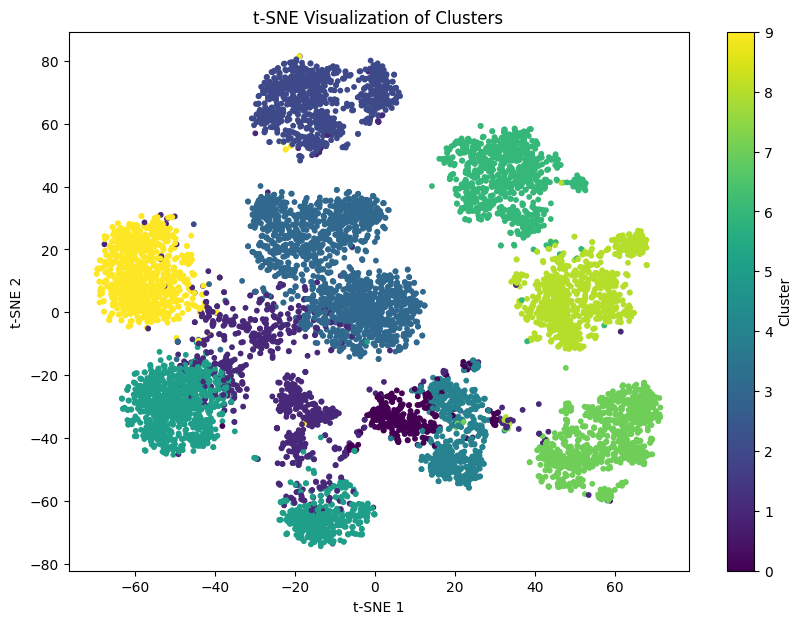

In [15]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(label="Cluster")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()